In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
df = pd.read_csv('CP_count_Ha.csv')

In [2]:

df

,InChIKey,737823,737824,688422,688810,688812,688816,688724,688739,688759,...,Cells_Neighbors_FirstClosestObjectNumber_Adjacent,Cells_Neighbors_SecondClosestObjectNumber_5,Cells_Neighbors_SecondClosestObjectNumber_Adjacent,Cells_Parent_Nuclei,Cytoplasm_Number_Object_Number,Cytoplasm_Parent_Cells,Cytoplasm_Parent_Nuclei,Nuclei_Neighbors_FirstClosestObjectNumber_1,Nuclei_Neighbors_SecondClosestObjectNumber_1,Nuclei_Number_Object_Number
0,IENZQIKPVFGBNW-UHFFFAOYSA-N,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-15.605469,-14.804688,-14.804688,-15.648438,-15.648438,-15.648438,-15.648438,-16.062500,-15.687500,-15.648438
1,GSDSWSVVBLHKDQ-UHFFFAOYSA-N,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,3.030769,3.807692,3.807692,3.607692,3.607692,3.607692,3.607692,3.123077,4.588462,3.607692
2,CGIGDMFJXJATDK-UHFFFAOYSA-N,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-6.011719,-5.312500,-5.312500,-6.164062,-6.164062,-6.164062,-6.164062,-5.976562,-6.132812,-6.164062
3,DSXXEELGXBCYNQ-UHFFFAOYSA-N,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-31.820312,-31.812500,-31.812500,-31.828125,-31.828125,-31.828125,-31.828125,-31.835938,-32.304688,-31.828125
4,MYSWGUAQZAJSOK-UHFFFAOYSA-N,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,4.070312,3.593750,3.593750,3.617188,3.617188,3.617188,3.617188,4.078125,3.164062,3.617188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10521,YAJYINBQFXCAPI-WENCSYSZSA-N,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-3.171875,-3.062500,-3.062500,-3.625000,-3.632812,-3.625000,-3.625000,-3.125000,-2.953125,-3.632812
10522,DIBJIDYNEHVBAV-KFRKLSNLSA-N,-1,-1,-1,-1,-1,-1,-1,0,-1,...,-2.031250,-1.648438,-1.648438,-3.046875,-3.046875,-3.046875,-3.046875,-2.468750,-2.132812,-3.046875
10523,YAJYINBQFXCAPI-VPYPWEPUSA-N,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-0.804688,-2.265625,-2.265625,-1.875000,-1.875000,-1.875000,-1.875000,-1.351562,-2.718750,-1.875000
10524,YAJYINBQFXCAPI-RZIGYZOXSA-N,-1,-1,-1,0,-1,-1,-1,-1,0,...,0.820312,0.843750,0.843750,1.796875,1.796875,1.796875,1.796875,1.101562,1.281250,1.796875


In [3]:
df["845196"].value_counts()

-1    10145
 1      255
 0      126
Name: 845196, dtype: int64

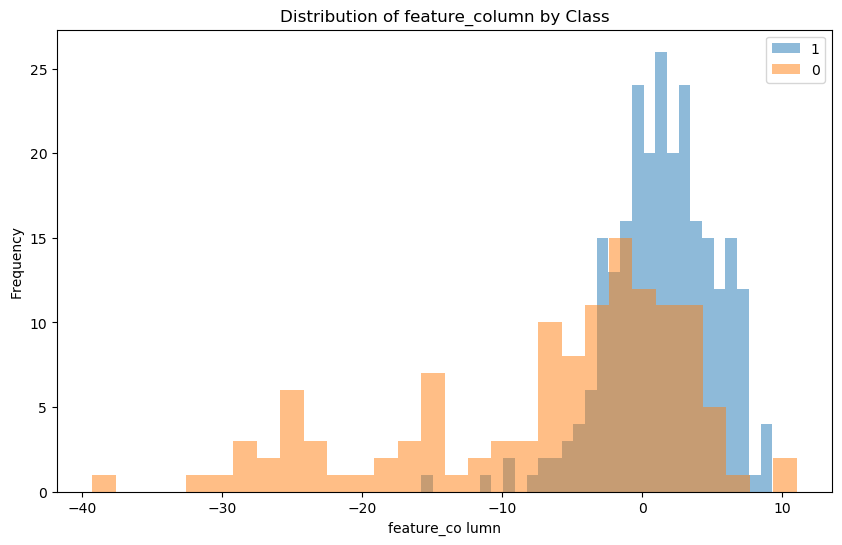

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


# Filter the data by class
data_class1 = df[df['845196'] == 1]['Cells_Number_Object_Number']
data_class2 = df[df['845196'] == 0]['Cells_Number_Object_Number']

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(data_class1, alpha=0.5, label='1', bins=30)
plt.hist(data_class2, alpha=0.5, label='0', bins=30)
plt.title('Distribution of feature_column by Class')
plt.xlabel('feature_co lumn')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [5]:
(1-4000)/4000

-0.99975

In [75]:
import json

# Load the JSON file containing the task splits
with open('data/output/data_split.json', 'r') as f:
    task_splits = json.load(f)

train_tasks = task_splits['train']
test_tasks = task_splits['test']

In [76]:
import numpy as np
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV

missing_value_indicator = -1

# Initialize a list to store AUC scores for all folds
all_auc_scores = []

# Initialize lists to store data for the current fold's training set
X_train_combined = pd.DataFrame()
y_train_combined = pd.Series()

# Loop through all assays and collect data
for assay in train_tasks:
    train_data_assay = df[df[assay]!=-1].reset_index(drop=True)[[assay, "Cells_Number_Object_Number"]]

    # Append to combined training data
    X_train_combined = pd.concat([X_train_combined, train_data_assay[["Cells_Number_Object_Number"]]], axis=0)
    y_train_combined = pd.concat([y_train_combined, train_data_assay[assay].astype(int)], axis=0)
            
print(len(X_train_combined))
print(len(y_train_combined))

# Calculate class weights (balanced)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_combined), y=y_train_combined)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weight_dict)
    
# Calculate scale_pos_weight based on class weights
scale_pos_weight = class_weight_dict[0] / class_weight_dict[1]
print("scale_pos_weight: ", scale_pos_weight)
        
param_grid = {
'max_depth': [3, 5, 7],
'learning_rate': [0.01, 0.1, 0.3],
'n_estimators': [100, 200],
'scale_pos_weight': [scale_pos_weight],
'n_jobs' : [-1] 
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
param_grid=param_grid,
scoring='roc_auc',  # You can change this to a metric more suitable for imbalanced datasets (e.g., F1, AUC)
cv=stratified_kfold,
n_jobs=-1,
verbose=1
)

grid_search.fit(X_train_combined, y_train_combined)
best_clf = grid_search.best_estimator_

# Train the model on the combined data from other folds
# clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
best_clf.fit(X_train_combined, y_train_combined)
  
# Predict for each individual fold using the corresponding model
for assay in test_tasks:

    test_data_assay = df[df[assay]!=-1].reset_index(drop=True)[[assay, "Cells_Number_Object_Number"]]
        
    # Separate features and target variable
    X_test = test_data_assay[["Cells_Number_Object_Number"]]
    y_test = test_data_assay[assay].astype(int)

    if len(y_test) == 0:
        print(f"Skipping assay {assay} in fold {fold} due to no test data")
        continue
        
    # Make predictions using the model for the current fold
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]

    # Calculate AUC score
    auc_score = np.nan    
    try:
        auc_score = roc_auc_score(y_test, y_pred_proba)
    except:
        continue

    # Store the AUC score along with fold and assay information
    all_auc_scores.append({"Task": assay, "AUC_C": auc_score})

# Convert the AUC results to a DataFrame for convenience
auc_df = pd.DataFrame(all_auc_scores)

# Save the DataFrame to a CSV file
auc_df.to_csv("auc_scores_across_folds.csv", index=False)

# Display the AUC DataFrame
auc_df


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


39637
39637
{0: 0.7185041511075663, 1: 1.6441430230628837}
scale_pos_weight:  0.4370083022151325
Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Task,AUC_C
0,688267,0.600979
1,600886,0.525034
2,737826,0.535589
3,737824_1,0.557364
4,737825,0.570937
5,1495405,0.752043
6,737053,0.428189
7,737400,0.574029
8,736947,0.646930
9,752347,0.618600


In [78]:
print(len(auc_df[auc_df["AUC_C"]>0.7]))
auc_df.AUC_C.mean()

4


0.5866098568115768

In [42]:
# Reverse Model


import numpy as np
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

missing_value_indicator = -1

# Initialize a list to store AUC scores for all folds
all_auc_scores = []

# Initialize lists to store data for the current fold's training set
X_train_combined = pd.DataFrame()
y_train_combined = pd.Series()

# Loop through all assays and collect data
for assay in train_tasks:
    train_data_assay = df[df[assay]!=-1].reset_index(drop=True)[[assay, "Cells_Number_Object_Number"]]

    # Append to combined training data
    X_train_combined = pd.concat([X_train_combined, train_data_assay[["Cells_Number_Object_Number"]]], axis=0)
    y_train_combined = pd.concat([y_train_combined, train_data_assay[assay].astype(int)], axis=0)
            
print(len(X_train_combined))
print(len(y_train_combined))

# Calculate class weights (balanced)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_combined), y=y_train_combined)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weight_dict)
    
# Calculate scale_pos_weight based on class weights
scale_pos_weight = class_weight_dict[0] / class_weight_dict[1]
print("scale_pos_weight: ", scale_pos_weight)
        
param_grid = {
'max_depth': [3, 5, 7],
'learning_rate': [0.01, 0.1, 0.3],
'n_estimators': [100, 200],
'scale_pos_weight': [scale_pos_weight]  # Keep class weight fixed
}

grid_search = GridSearchCV(
estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
param_grid=param_grid,
scoring='roc_auc',  # You can change this to a metric more suitable for imbalanced datasets (e.g., F1, AUC)
cv=5,
n_jobs=-1,
verbose=1
)

grid_search.fit(X_train_combined, y_train_combined)
best_clf = grid_search.best_estimator_

# Train the model on the combined data from other folds
# clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
best_clf.fit(X_train_combined, y_train_combined)

# Predict for each individual fold using the corresponding model
for assay in test_tasks:

    test_data_assay = df[df[assay]!=-1].reset_index(drop=True)[[assay, "Cells_Number_Object_Number"]]
        
    # Separate features and target variable
    X_test = test_data_assay[["Cells_Number_Object_Number"]]
    y_test = test_data_assay[assay].astype(int)

    if len(y_test) == 0:
        print(f"Skipping assay {assay} in fold {fold} due to no test data")
        continue
        
    # Make predictions using the model for the current fold
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
    y_pred_proba = 1-y_pred_proba
    # Calculate AUC score
    auc_score = np.nan    
    try:
        auc_score = roc_auc_score(y_test, y_pred_proba)
    except:
        continue

    # Store the AUC score along with fold and assay information
    all_auc_scores.append({"Task": assay, "AUC_r": auc_score})

# Convert the AUC results to a DataFrame for convenience
auc_df_r = pd.DataFrame(all_auc_scores)

# Save the DataFrame to a CSV file
auc_df_r.to_csv("auc_scores_r_across_folds.csv", index=False)

# Display the AUC DataFrame
auc_df_r


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


39637
39637
{0: 0.7185041511075663, 1: 1.6441430230628837}
scale_pos_weight:  0.4370083022151325
Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Task,AUC_r
0,688267,0.399021
1,600886,0.474966
2,737826,0.464411
3,737824_1,0.442636
4,737825,0.429063
5,1495405,0.247957
6,737053,0.571811
7,737400,0.425971
8,736947,0.353070
9,752347,0.381400
